In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import tree

In [35]:
from sklearn.preprocessing import LabelEncoder

Получение данных

In [68]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [37]:
train.head()

,Tectonic regime,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,OFFSHORE,OIL,DEVELOPING,INVERSION/WRENCH,3520,NEOGENE,SANDSTONE,2460.0,220.0,20.0,45.0
1,GRAVITY/EXTENSION/EVAPORITE,OFFSHORE,OIL,MATURE PRODUCTION,SALT/PASSIVE MARGIN,9967,CRETACEOUS,LIMESTONE,427.0,160.0,19.0,175.0
2,GRAVITY/EXTENSION/EVAPORITE,ONSHORE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,8700,CRETACEOUS,LIMESTONE,95.0,15.0,12.0,20.0
3,COMPRESSION,ONSHORE,OIL,DECLINING PRODUCTION,THRUST,5084,CRETACEOUS,SANDSTONE,328.0,300.0,13.0,600.0
4,INVERSION/COMPRESSION/EXTENSION,ONSHORE,OIL,DECLINING PRODUCTION,INVERSION/RIFT,1030,CRETACEOUS,SANDSTONE,260.0,33.0,24.0,182.0


Обработка данных

In [71]:
labelencoder = LabelEncoder()

In [69]:
all_data = pd.concat([train, test], axis=0)

In [70]:
train_full = all_data.copy()
train_full = train_full['Tectonic regime'].str.get_dummies('/')

In [72]:
train_full.columns = train_full.columns.str.split().str[0]

In [73]:
train_full = train_full.add_prefix('regime_')

In [74]:
train_full = pd.concat([all_data, train_full], axis=1)
train_full.drop('Tectonic regime', axis=1, inplace=True)

In [75]:
tmp = all_data.copy()
tmp = tmp['Structural setting'].str.get_dummies('/')
tmp.columns = tmp.columns.str.split().str[0]
tmp = tmp.add_prefix('struct_')
train_full = pd.concat([train_full, tmp], axis=1)
train_full.drop('Structural setting', axis=1, inplace=True)

In [76]:
train_full.head()

,Onshore/Offshore,Hydrocarbon type,Reservoir status,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability,regime_BASEMENT-I,regime_COMPRESSION,regime_DIAPIR,regime_EROSION,regime_EVAPORITE,regime_EXTENSION,regime_GRAVITY,regime_INVERSION,regime_LINKED,regime_REACTIVATION,regime_SHALE,regime_STRIKE-SLIP,regime_SYNSEDIMENTATION,regime_TRANSPRESSION,regime_TRANSTENSION,regime_UPLIFT,struct_BACKARC,struct_DELTA,struct_FOREARC,struct_FORELAND,struct_INTRACRATONIC,struct_INVERSION,struct_PASSIVE,struct_RIFT,struct_SALT,struct_SUB-SALT,struct_SUB-THRUST,struct_THRUST,struct_WRENCH
0,OFFSHORE,OIL,DEVELOPING,3520,NEOGENE,SANDSTONE,2460.0,220.0,20.0,45.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,OFFSHORE,OIL,MATURE PRODUCTION,9967,CRETACEOUS,LIMESTONE,427.0,160.0,19.0,175.0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,ONSHORE,OIL,MATURE PRODUCTION,8700,CRETACEOUS,LIMESTONE,95.0,15.0,12.0,20.0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,ONSHORE,OIL,DECLINING PRODUCTION,5084,CRETACEOUS,SANDSTONE,328.0,300.0,13.0,600.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,ONSHORE,OIL,DECLINING PRODUCTION,1030,CRETACEOUS,SANDSTONE,260.0,33.0,24.0,182.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [77]:
print(train_full['Hydrocarbon type'].value_counts())
print('=============================================')
print(train_full['Reservoir status'].value_counts())
print('=============================================')
print(train_full['Period'].value_counts())
print('=============================================')
print(train_full['Lithology'].value_counts())

OIL                332
GAS                 68
GAS-CONDENSATE      38
CARBON DIOXIDE       2
BITUMEN              1
METHANE HYDRATE      1
Name: Hydrocarbon type, dtype: int64
DECLINING PRODUCTION        131
MATURE PRODUCTION            86
NEARLY DEPLETED              82
PLATEAU PRODUCTION           39
DEVELOPING                   28
REJUVENATING                 27
UNKNOWN                      13
UNDEVELOPED                  11
SECOND PLATEAU PRODUTION      8
CONTINUING DEVELOPMENT        7
ABANDONED                     6
TEMPORARILY SHUT-IN           3
DEPLETED                      1
Name: Reservoir status, dtype: int64
CRETACEOUS                           113
NEOGENE                               63
JURASSIC                              58
PALEOGENE                             48
CARBONIFEROUS                         40
PERMIAN                               36
DEVONIAN                              22
TRIASSIC                              12
CRETACEOUS-PALEOGENE                   9
PRO

In [78]:
for col in ['Hydrocarbon type', 'Reservoir status', 'Period', 'Lithology']:
    tmp = all_data.copy()
    tmp = tmp[col].str.get_dummies()
    tmp.columns = tmp.columns.str.split().str[0]
    tmp = tmp.add_prefix(col[0])
    train_full = pd.concat([train_full, tmp], axis=1)
    train_full.drop(col, axis=1, inplace=True)

In [79]:
train_full.head()

,Onshore/Offshore,Depth,Gross,Netpay,Porosity,Permeability,regime_BASEMENT-I,regime_COMPRESSION,regime_DIAPIR,regime_EROSION,regime_EVAPORITE,regime_EXTENSION,regime_GRAVITY,regime_INVERSION,regime_LINKED,regime_REACTIVATION,regime_SHALE,regime_STRIKE-SLIP,regime_SYNSEDIMENTATION,regime_TRANSPRESSION,regime_TRANSTENSION,regime_UPLIFT,struct_BACKARC,struct_DELTA,struct_FOREARC,struct_FORELAND,struct_INTRACRATONIC,struct_INVERSION,struct_PASSIVE,struct_RIFT,struct_SALT,struct_SUB-SALT,struct_SUB-THRUST,struct_THRUST,struct_WRENCH,HBITUMEN,HCARBON,HGAS,HGAS-CONDENSATE,HMETHANE,...,PCARBONIFEROUS-CRETACEOUS,PCARBONIFEROUS-PERMIAN,PCRETACEOUS,PCRETACEOUS-PALEOGENE,PDEVONIAN,PDEVONIAN-CARBONIFEROUS,PDEVONIAN-PERMIAN,PJURASSIC,PJURASSIC-CRETACEOUS,PMESOZOIC,PNEOGENE,PORDOVICIAN,PPALEOGENE,PPALEOGENE-NEOGENE,PPALEOZOIC,PPALEOZOIC-CRETACEOUS,PPERMIAN,PPERMIAN-TRIASSIC,PPROTEROZOIC,PPROTEROZOIC-CAMBRIAN,PSILURIAN,PTRIASSIC,PTRIASSIC-JURASSIC,LBASEMENT,LCHALK,LCHALKY,LCHERT,LCONGLOMERATE,LDIATOMITE,LDOLOMITE,LDOLOMITIC,LGLAUCONITIC,LLIMESTONE,LLOW-RESISTIVITY,LSANDSTONE,LSHALE,LSHALY,LSILTSTONE,LTHINLY-BEDDED,LVOLCANICS
0,OFFSHORE,3520,2460.0,220.0,20.0,45.0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,OFFSHORE,9967,427.0,160.0,19.0,175.0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,ONSHORE,8700,95.0,15.0,12.0,20.0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,ONSHORE,5084,328.0,300.0,13.0,600.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,ONSHORE,1030,260.0,33.0,24.0,182.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Балансировка выборки

In [18]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [80]:
os = SMOTE(random_state=0, k_neighbors=3)

X = train_full[:309].drop('Onshore/Offshore', axis=1)
y = train_full['Onshore/Offshore'][:309]

column = X.columns
print('До балансировки:')
print(X.shape)
print(y.value_counts())
print('----------------------------------')

X_sample, y_sample = os.fit_sample(X, y)

X_sample = pd.DataFrame(data= X_sample, columns=column)
y_sample = pd.DataFrame(data=y_sample, columns=['Onshore/Offshore'])

print('После балансировки ', X_sample.shape)
print(y_sample.value_counts())

До балансировки:
(309, 98)
ONSHORE             211
OFFSHORE             93
ONSHORE-OFFSHORE      5
Name: Onshore/Offshore, dtype: int64
----------------------------------
После балансировки  (633, 98)
Onshore/Offshore
ONSHORE-OFFSHORE    211
ONSHORE             211
OFFSHORE            211
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Нормализация данных

In [49]:
from sklearn.preprocessing import MinMaxScaler

In [82]:
scaler = MinMaxScaler(feature_range=(0,1))
X_sample_norm = scaler.fit_transform(X_sample)
X_sample_norm

array([[0.18508132, 0.2334827 , 0.07392473, ..., 0.        , 0.        ,
        0.        ],
       [0.54666293, 0.0396606 , 0.05376344, ..., 0.        , 0.        ,
        0.        ],
       [0.47560292, 0.00800839, 0.00504032, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3261441 , 0.0990556 , 0.06178447, ..., 0.        , 0.        ,
        0.        ],
       [0.14605751, 0.06252495, 0.11167521, ..., 0.        , 0.81042409,
        0.        ],
       [0.17936881, 0.04797372, 0.04604689, ..., 0.        , 0.        ,
        0.        ]])

In [53]:
train_full['Onshore/Offshore'][:309] = labelencoder.fit_transform(train_full['Onshore/Offshore'][:309])
train_full.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Onshore/Offshore,Depth,Gross,Netpay,Porosity,Permeability,regime_BASEMENT-I,regime_COMPRESSION,regime_DIAPIR,regime_EROSION,regime_EVAPORITE,regime_EXTENSION,regime_GRAVITY,regime_INVERSION,regime_LINKED,regime_REACTIVATION,regime_SHALE,regime_STRIKE-SLIP,regime_SYNSEDIMENTATION,regime_TRANSPRESSION,regime_TRANSTENSION,regime_UPLIFT,struct_BACKARC,struct_DELTA,struct_FOREARC,struct_FORELAND,struct_INTRACRATONIC,struct_INVERSION,struct_PASSIVE,struct_RIFT,struct_SALT,struct_SUB-SALT,struct_SUB-THRUST,struct_THRUST,struct_WRENCH,HBITUMEN,HCARBON,HGAS,HGAS-CONDENSATE,HMETHANE,...,PCARBONIFEROUS-CRETACEOUS,PCARBONIFEROUS-PERMIAN,PCRETACEOUS,PCRETACEOUS-PALEOGENE,PDEVONIAN,PDEVONIAN-CARBONIFEROUS,PDEVONIAN-PERMIAN,PJURASSIC,PJURASSIC-CRETACEOUS,PMESOZOIC,PNEOGENE,PORDOVICIAN,PPALEOGENE,PPALEOGENE-NEOGENE,PPALEOZOIC,PPALEOZOIC-CRETACEOUS,PPERMIAN,PPERMIAN-TRIASSIC,PPROTEROZOIC,PPROTEROZOIC-CAMBRIAN,PSILURIAN,PTRIASSIC,PTRIASSIC-JURASSIC,LBASEMENT,LCHALK,LCHALKY,LCHERT,LCONGLOMERATE,LDIATOMITE,LDOLOMITE,LDOLOMITIC,LGLAUCONITIC,LLIMESTONE,LLOW-RESISTIVITY,LSANDSTONE,LSHALE,LSHALY,LSILTSTONE,LTHINLY-BEDDED,LVOLCANICS
0,0,0.167785,0.196093,0.073925,0.350649,0.005999,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0.495577,0.033309,0.053763,0.332096,0.023332,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1,0.431157,0.006726,0.005040,0.202226,0.002665,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0.247305,0.025382,0.100806,0.220779,0.079999,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0.041184,0.019938,0.011089,0.424861,0.024265,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Метод опорных векторов

In [83]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score:
0.9371069182389937
AxesSubplot(0.125,0.125;0.62x0.755)


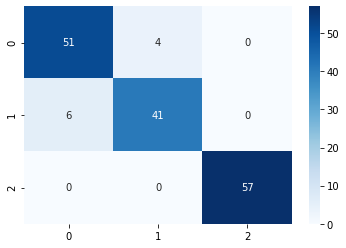

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_sample_norm, y_sample, test_size = 0.25, random_state = 1)

svcmodel = SVC()

svcmodel.fit(X_train, y_train)

svc_pred = svcmodel.predict(X_test)
confus = confusion_matrix(y_test, svc_pred)

print('================================================')
print('Accuracy score:')
print(accuracy_score(y_test, svc_pred))
print('================================================')
print(sns.heatmap(data=confus, annot=True, cmap='Blues'))